In [68]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
from scipy.optimize import fsolve
import math

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.calculate_accuracy import calculate_acc
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN

from functools import partial

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [69]:
if not os.path.exists('constituents-financials.csv'):
    urllib.request.urlretrieve(
        "https://datahub.io/core/s-and-p-500-companies-financials/r/constituents-financials.csv", "constituents-financials.csv")
data = pd.read_csv('constituents-financials.csv')
data = data[['Price',	'Price/Earnings', 'Dividend Yield',	'Earnings/Share',
             '52 Week Low',	'52 Week High',	'Market Cap',	'EBITDA',
             'Price/Sales',	'Price/Book', 'Sector']]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
data


,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,Sector
0,222.89000,24.31000,2.33286,7.92000,259.77000,175.49000,138721055226,9048000000.00000,4.39027,11.34000,Industrials
1,60.24000,27.76000,1.14796,1.70000,68.39000,48.92500,10783419933,601000000.00000,3.57548,6.35000,Industrials
2,56.27000,22.51000,1.90898,0.26000,64.60000,42.28000,102121042306,5744000000.00000,3.74048,3.19000,Health Care
3,108.48000,19.41000,2.49956,3.29000,125.86000,60.05000,181386347059,10310000000.00000,6.29157,26.14000,Health Care
4,150.51000,25.47000,1.71447,5.44000,162.60000,114.82000,98765855553,5643228000.00000,2.60412,10.62000,Information Technology
...,...,...,...,...,...,...,...,...,...,...,...
490,70.24000,30.94000,1.17008,1.83000,76.81000,46.86000,12915021000,722000000.00000,2.72621,5.31000,Industrials
491,76.30000,27.25000,1.79708,4.07000,86.93000,62.85000,27003303098,2289000000.00000,6.31364,212.08000,Consumer Discretionary
492,115.53000,14.32000,0.79483,9.01000,133.49000,108.17000,24454698119,2007400000.00000,3.16490,2.39000,Health Care
493,50.71000,17.73000,1.48093,2.60000,55.61000,38.43000,10670678640,0.00000,3.79458,1.42000,Financials


# Approximating Price distribution using Inverse Transform

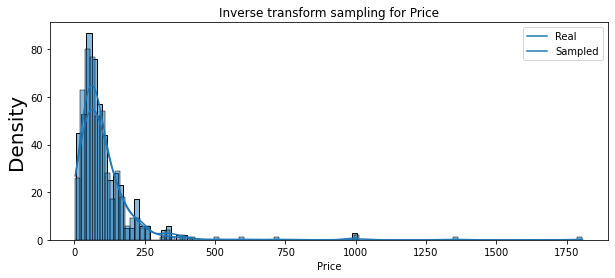

In [87]:
def inv_trans_sampling(data, num_samples=1000):
    #finding num ding
    bins = sns.distributions._freedman_diaconis_bins(data)
    # creating curve p(x)
    hist, bin_edges = np.histogram(data.values, bins=bins, density=True)

    cum_values = np.zeros(bin_edges.shape)
    # integrating and saving square under the curve, because
    # F(x) = P(X <= x)
    cum_values[1:] = np.cumsum(hist * np.diff(bin_edges))
    #interpl
    inversed_cdf = partial(np.interp, xp=cum_values, fp=bin_edges)
    #creating sampling data
    uniform_values = np.random.rand(num_samples)
    return inversed_cdf(uniform_values)

inverse = inv_trans_sampling(data['Price'], len(data['Price']))
plt.figure(figsize=(10, 4))
sns.histplot(inverse, kde=True)
sns.histplot(data['Price'], kde=True)
plt.ylabel('Density', fontsize=20)
plt.title('Inverse transform sampling for Price')
plt.legend(['Real', 'Sampled'])

# Approximating Price using Accept-Reject sampling

C:\Users\morko\AppData\Local\Temp/ipykernel_19332/997392838.py:3: RuntimeWarning: divide by zero encountered in log
  exp = np.exp(-(np.log(x) - mu_)**2 / (2 * sigma_ ** 2))
C:\Users\morko\AppData\Local\Temp/ipykernel_19332/997392838.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return exp / frac


Text(0.5, 1.0, 'M=3')

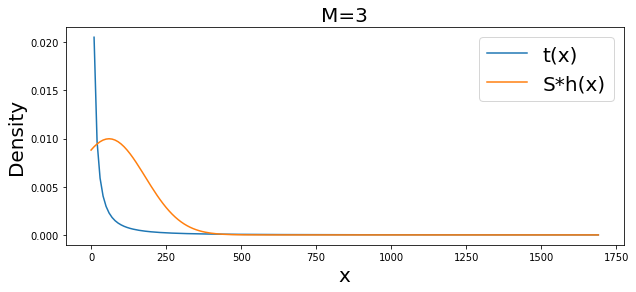

In [71]:
# lognormal PDF
def lognorm_pdf(x, mu_, sigma_):
    exp = np.exp(-(np.log(x) - mu_)**2 / (2 * sigma_ ** 2))
    frac = (x * sigma_ * (2 * np.pi) ** 0.5)
    return exp / frac

# normal PDF


def g(x, mu_, sigma_):
    return 1/np.sqrt(2*np.pi)/sigma_ * np.exp(-0.5*((x-mu_)/sigma_)**2)

upper_params = 60, 120

M = 3
x_vals = np.arange(0, 1700, 10)
f_vals = [lognorm_pdf(x, mu, sigma) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.figure(figsize=(10, 4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['t(x)', 'S*h(x)'], fontsize=20)

plt.title("M=%s" % M, fontsize=20)


C:\Users\morko\AppData\Local\Temp/ipykernel_19332/997392838.py:3: RuntimeWarning: invalid value encountered in log
  exp = np.exp(-(np.log(x) - mu_)**2 / (2 * sigma_ ** 2))


Num Samples Collected: 17639
Efficiency: 0.176


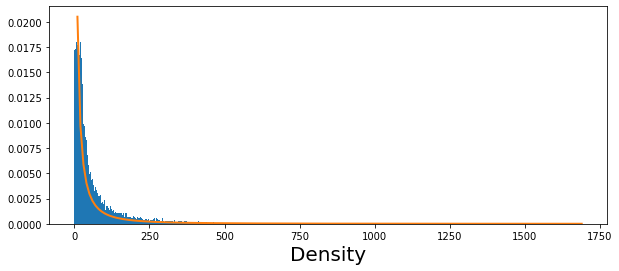

In [72]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 100000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = lognorm_pdf(candidate, mu, sigma) / (M*g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(10, 4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)
# plt.ylim(0, 0.015)
print("Num Samples Collected: %s"%len(samples))
print("Efficiency: %s"%round(len(samples) / N, 3))
# .title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(samples), 2), round(np.mean(TRUE_EXP), 2)), fontsize=20)


# Approximating Dividend Yield distribution using Inverse Transform

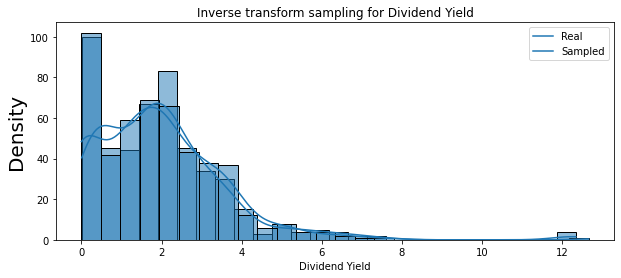

In [73]:

inverse = inv_trans_sampling(data['Dividend Yield'], len(data))
plt.figure(figsize=(10, 4))
sns.histplot(inverse, kde=True)
sns.histplot(data['Dividend Yield'], kde=True)
plt.ylabel('Density', fontsize=20)
plt.title('Inverse transform sampling for Dividend Yield')
plt.legend(['Real', 'Sampled'])

# Approximating Dividend Yield using Accept-Reject sampling

C:\Users\morko\AppData\Local\Temp/ipykernel_19332/4216565273.py:5: RuntimeWarning: divide by zero encountered in log
  exp = np.exp(-(np.log(x) - mu)**2 / (2 * sigma ** 2))
C:\Users\morko\AppData\Local\Temp/ipykernel_19332/4216565273.py:7: RuntimeWarning: invalid value encountered in double_scalars
  return exp / frac


Text(0.5, 1.0, 'M=2')

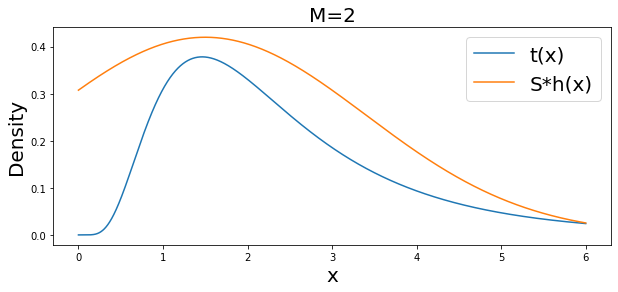

In [74]:
mu = 0.7423118497542172
sigma = 0.6016495934841037
# lognormal PDF
def lognorm_pdf(x, mu, sigma):
    exp = np.exp(-(np.log(x) - mu)**2 / (2 * sigma ** 2))
    frac = (x * sigma * (2 * np.pi) ** 0.5)
    return exp / frac

# normal PDF


def g(x, mu, sigma):
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

upper_params = 1.5, 1.9
M = 2
x_vals = np.arange(0, 6, 1e-4)
f_vals = [lognorm_pdf(x, mu, sigma) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.figure(figsize=(10, 4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['t(x)', 'S*h(x)'], fontsize=20)

plt.title("M=%s" % M, fontsize=20)


C:\Users\morko\AppData\Local\Temp/ipykernel_19332/4216565273.py:5: RuntimeWarning: invalid value encountered in log
  exp = np.exp(-(np.log(x) - mu)**2 / (2 * sigma ** 2))


Num Samples Collected: 48911
Efficiency: 0.489


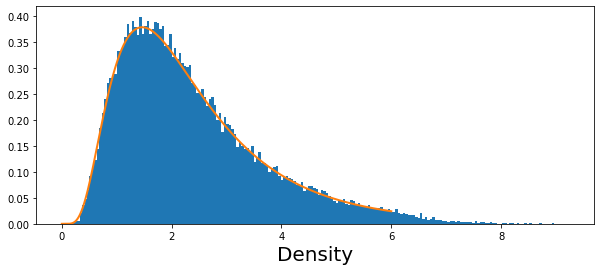

In [75]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 100000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = lognorm_pdf(candidate, mu, sigma) / (M*g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(10, 4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)
# plt.ylim(0, 0.015)
print("Num Samples Collected: %s"%len(samples))
print("Efficiency: %s"%round(len(samples) / N, 3))
# .title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(samples), 2), round(np.mean(TRUE_EXP), 2)), fontsize=20)


# Approximating Earnings/Share using Inverse Transform Sampling

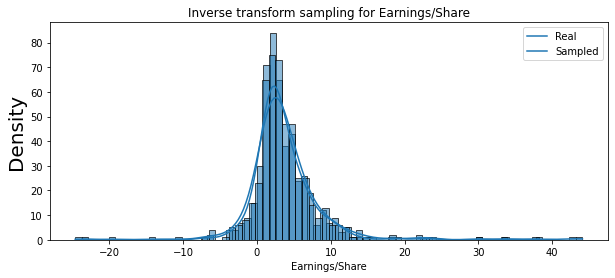

In [76]:
inverse = inv_trans_sampling(data['Earnings/Share'], len(data['Earnings/Share']))
plt.figure(figsize=(10, 4))
sns.histplot(inverse, kde=True)
sns.histplot(data['Earnings/Share'], kde=True)
# plt.hist(data['Earnings/Share'], bins=200, density=True)
# plt.hist(inverse[0] , bins=200, density=True)
plt.ylabel('Density', fontsize=20)
plt.title('Inverse transform sampling for Earnings/Share')
plt.legend(['Real', 'Sampled'])

# Approximating Earnings/Share using Accept Reject Sampling

Num Samples Collected: 49849
Efficiency: 0.498


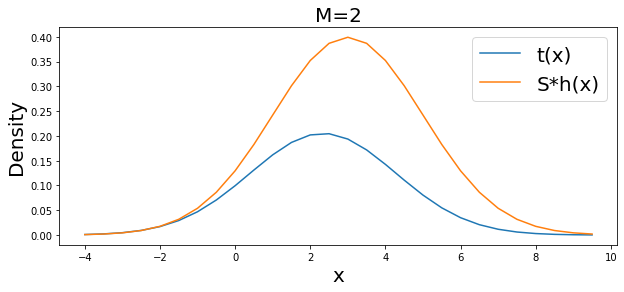

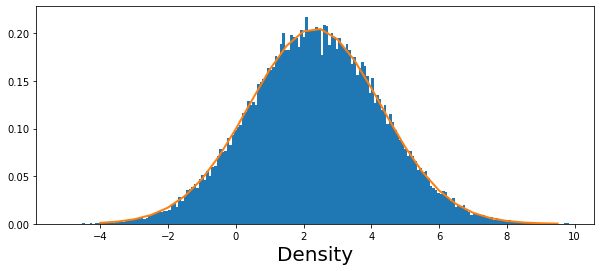

In [77]:
# normal PDF
mu = 2.3402284263959388
sigma = 1.9454675161643853
def normal_pdf(x, mu_, sigma_):
    
    return 1/np.sqrt(2*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

# normal PDF


def g(x, mu_, sigma_):
    return 1/np.sqrt(2*np.pi)/sigma_ * np.exp(-0.5*((x-mu_)/sigma_)**2)

upper_params = 3, 2

M = 2
x_vals = np.arange(-4, 10, 0.5)
f_vals = [normal_pdf(x, mu, sigma) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.figure(figsize=(10, 4))
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M*g_vals)
plt.xlabel('x', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend(['t(x)', 'S*h(x)'], fontsize=20)

plt.title("M=%s" % M, fontsize=20)

# collect all accepted samples here
samples = []

# try this many candidates
N = 100000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept =normal_pdf(candidate, mu, sigma) / (M*g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(10, 4))
plt.hist(samples, bins=200, density=True)
plt.xlabel('x', fontsize=20)
plt.xlabel('Density', fontsize=20)
plt.plot(x_vals, [f for f in f_vals], linewidth=2)
# plt.ylim(0, 0.015)
print("Num Samples Collected: %s"%len(samples))
print("Efficiency: %s"%round(len(samples) / N, 3))
# .title('Empirical Exp. Value: %s\nTrue Exp. Value: %s'%(round(np.mean(samples), 2), round(np.mean(TRUE_EXP), 2)), fontsize=20)

# Estimating correlations between targets and predictors

In [78]:
data.corr()

,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book
Price,1.00000,0.19917,-0.24534,0.60903,0.99508,0.98277,0.40775,0.18064,0.18108,0.02351
Price/Earnings,0.19917,1.00000,-0.20088,0.00888,0.18976,0.14763,0.13256,0.00081,0.18701,0.00037
Dividend Yield,-0.24534,-0.20088,1.00000,-0.08826,-0.24542,-0.20907,-0.02687,0.12239,-0.08112,0.08907
Earnings/Share,0.60903,0.00888,-0.08826,1.00000,0.60611,0.62302,0.19443,0.17794,-0.03933,0.03164
52 Week Low,0.99508,0.18976,-0.24542,0.60611,1.00000,0.98489,0.39983,0.17677,0.18849,0.02318
52 Week High,0.98277,0.14763,-0.20907,0.62302,0.98489,1.00000,0.37585,0.17930,0.17288,0.01765
Market Cap,0.40775,0.13256,-0.02687,0.19443,0.39983,0.37585,1.00000,0.77072,0.09393,0.03422
EBITDA,0.18064,0.00081,0.12239,0.17794,0.17677,0.17930,0.77072,1.00000,-0.03793,0.03530
Price/Sales,0.18108,0.18701,-0.08112,-0.03933,0.18849,0.17288,0.09393,-0.03793,1.00000,0.01230
Price/Book,0.02351,0.00037,0.08907,0.03164,0.02318,0.01765,0.03422,0.03530,0.01230,1.00000


# Building Bayes Network on Correlation Analysis

Nodes type:
 {'Price': 'cont', 'Price/Earnings': 'cont', 'Dividend Yield': 'cont', 'Earnings/Share': 'cont', '52 Week Low': 'cont', '52 Week High': 'cont', 'Market Cap': 'cont', 'EBITDA': 'cont', 'Price/Sales': 'cont', 'Price/Book': 'cont', 'Sector': 'disc'}
Nodes sign:
 {'Price': 'pos', 'Price/Earnings': 'neg', 'Dividend Yield': 'pos', 'Earnings/Share': 'neg', '52 Week Low': 'pos', '52 Week High': 'pos', 'EBITDA': 'neg', 'Price/Sales': 'pos', 'Price/Book': 'pos', 'Market Cap': 'pos'}
Obtained network structure {'V': ['Price', 'Price/Earnings', 'Dividend Yield', 'Earnings/Share', '52 Week Low', '52 Week High', 'Market Cap', 'EBITDA', 'Price/Sales', 'Price/Book', 'Sector'], 'E': [['52 Week High', 'Price'], ['52 Week Low', 'Price'], ['Market Cap', 'Price'], ['52 Week High', 'Dividend Yield'], ['52 Week Low', 'Dividend Yield'], ['Price', 'Dividend Yield'], ['52 Week High', 'Price/Earnings'], ['Price/Sales', 'Price/Earnings'], ['Price', 'Price/Earnings'], ['Dividend Yield', 'Price/Earnings

G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

({}, {'Price': 13.124, 'Dividend Yield': 1.498, 'Earnings/Share': 5.525})


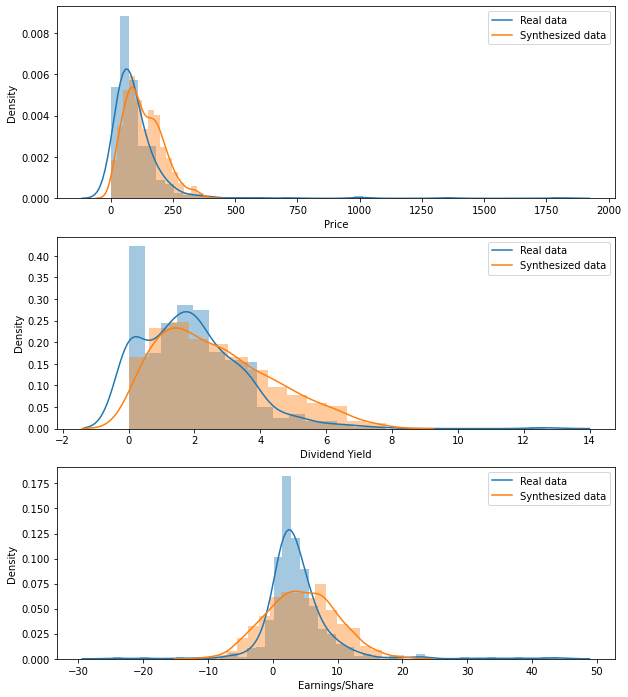

In [79]:

nodes_type = get_nodes_type(data)
nodes_type['Market Cap'] = 'cont'
print("Nodes type:\n", nodes_type)
nodes_sign = get_nodes_sign(data)
nodes_sign['Market Cap'] = 'pos'
print("Nodes sign:\n", nodes_sign)
bayes_manual = dict(
    {'V': ['Price',
           'Price/Earnings',
           'Dividend Yield',
           'Earnings/Share',
           '52 Week Low',
           '52 Week High',
           'Market Cap',
           'EBITDA',
           'Price/Sales',
           'Price/Book',
           'Sector'],
     'E': [

        ['52 Week High', 'Price'],
        ['52 Week Low', 'Price'],
        ['Market Cap', 'Price'],

        ['52 Week High', 'Dividend Yield'],
        ['52 Week Low', 'Dividend Yield'],
        ['Price', 'Dividend Yield'],


        ['52 Week High', 'Price/Earnings'],
        ['Price/Sales', 'Price/Earnings'],
        ['Price', 'Price/Earnings'],
        ['Dividend Yield', 'Price/Earnings'],
    ]
    }
)
print("Obtained network structure", bayes_manual)

draw_BN(bayes_manual, nodes_type, 's&p_bayes_manual')

params = parameter_learning(data, nodes_type, bayes_manual, 'simple')
save_structure(bayes_manual, 's&p_bayes_manual_structure')
skel = read_structure('s&p_bayes_manual_structure')
save_params(params, 's&p_bayes_manual_params')
params = read_params('s&p_bayes_manual_params')
bayes_manual = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_manual, nodes_sign, 'simple', 800)

fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(data['Price'], ax=ax[0])
sns.distplot(synth_df['Price'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Dividend Yield'], ax=ax[1])
sns.distplot(synth_df['Dividend Yield'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Earnings/Share'], ax=ax[2])
sns.distplot(synth_df['Earnings/Share'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_manual, data, [
      'Price', 'Dividend Yield', 'Earnings/Share'], 'simple')[0:2])


# Bayes Network (HC algorithm)

In [80]:

coded_data, coder = code_categories(
    data, 'label', ['Sector'])
discrete_data, coder = discretization(coded_data, 'equal_frequency',
                                      ['Price',	'Price/Earnings', 'Dividend Yield',	'Earnings/Share',
                                       '52 Week Low',	'52 Week High',	'Market Cap',	'EBITDA',
                                       'Price/Sales',	'Price/Book'])
bayes_hc = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
print("Obtained network structure", bayes_hc)
draw_BN(bayes_hc, nodes_type, 's&p_bayes_hc')


params = parameter_learning(data, nodes_type, bayes_hc, 'simple')
save_structure(bayes_hc, 's&p_bayes_hc_structure')
skel = read_structure('s&p_bayes_hc_structure')
save_params(params, 'p_bayes_hc_params')
params = read_params('p_bayes_hc_params')
bayes_hc = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_hc, nodes_sign, 'simple', 800)


Obtained network structure {'V': ['Price', 'Price/Earnings', 'Dividend Yield', 'Earnings/Share', '52 Week Low', '52 Week High', 'Market Cap', 'EBITDA', 'Price/Sales', 'Price/Book', 'Sector'], 'E': [['Price', '52 Week Low'], ['Price/Earnings', 'Price/Sales'], ['Price/Earnings', 'Price'], ['Dividend Yield', 'Price/Earnings'], ['Dividend Yield', 'Price'], ['52 Week Low', '52 Week High'], ['52 Week High', 'Earnings/Share'], ['EBITDA', 'Market Cap'], ['Price/Book', 'Price/Earnings'], ['Price/Book', 'Price'], ['Sector', 'Dividend Yield'], ['Sector', 'Price/Sales'], ['Sector', 'Price/Book'], ['Sector', 'EBITDA']]}
saving on ../visualization_result/s&p_bayes_hc.html
g:\Programming\multidimensional_data_processing\BAMT\s&p_bayes_hc.html


G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

({}, {'Price': 138.957, 'Dividend Yield': 1.238, 'Earnings/Share': 4.322})


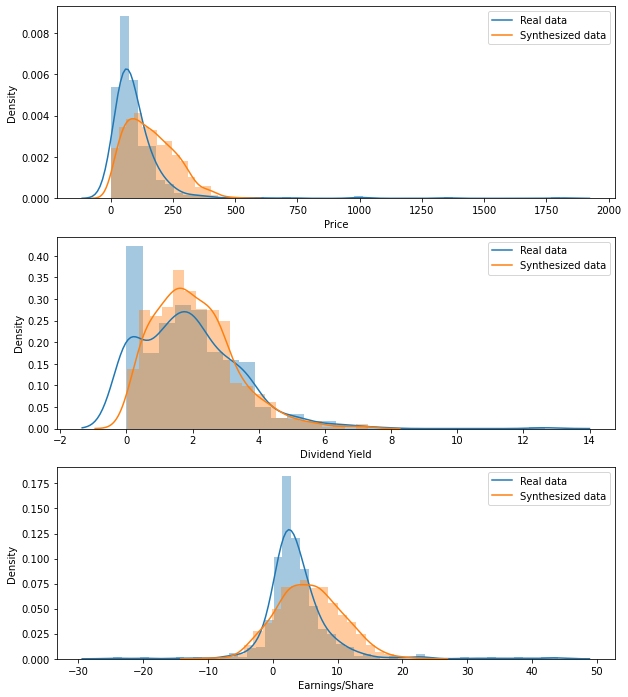

In [81]:
fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(data['Price'], ax=ax[0])
sns.distplot(synth_df['Price'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Dividend Yield'], ax=ax[1])
sns.distplot(synth_df['Dividend Yield'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Earnings/Share'], ax=ax[2])
sns.distplot(synth_df['Earnings/Share'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_hc, data, [
      'Price', 'Dividend Yield', 'Earnings/Share'], 'simple')[0:2])


# Bayes network (Evo algorithm)

In [82]:
bayes_evo = structure_learning(discrete_data, 'evo', nodes_type, 'MI')
print("Obtained network structure", bayes_evo)
draw_BN(bayes_evo, nodes_type, 's&p_bayes_evo')

params = parameter_learning(data, nodes_type, bayes_evo, 'simple')
save_structure(bayes_evo, 's&p_bayes_evo_structure')
skel = read_structure('s&p_bayes_evo_structure')
save_params(params, 's&p_bayes_evo_params')
params = read_params('s&p_bayes_evo_params')
bayes_evo = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_evo, nodes_sign, 'simple', 800)



G:\Programming\itmo_algorithms\itmo\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


Best metric is 11.5914
Generation num: 0
max_depth: 6, no improvements: 0
spent time: 0.1 min
Best metric is 11.5914
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 0.1 min
Best metric is 10.6294
Generation num: 2
max_depth: 6, no improvements: 0
spent time: 0.1 min
Best metric is 10.5225
Generation num: 3
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 10.5182
Generation num: 4
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 10.5134
Generation num: 5
max_depth: 6, no improvements: 0
spent time: 0.2 min
Best metric is 10.497499999999999
Generation num: 6
max_depth: 6, no improvements: 0
spent time: 0.3 min
Best metric is 10.497499999999999
Generation num: 7
max_depth: 6, no improvements: 1
spent time: 0.4 min
Best metric is 10.497499999999999
Generation num: 8
max_depth: 6, no improvements: 2
spent time: 0.4 min
Best metric is 10.497499999999999
Generation num: 9
max_depth: 6, no improvements: 3
spent time: 0.4 min
Best metric is 1

G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
G:\Programming\itmo_algorithms\itmo\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

({}, {'Price': 127.68, 'Dividend Yield': 1.522, 'Earnings/Share': 3.738})


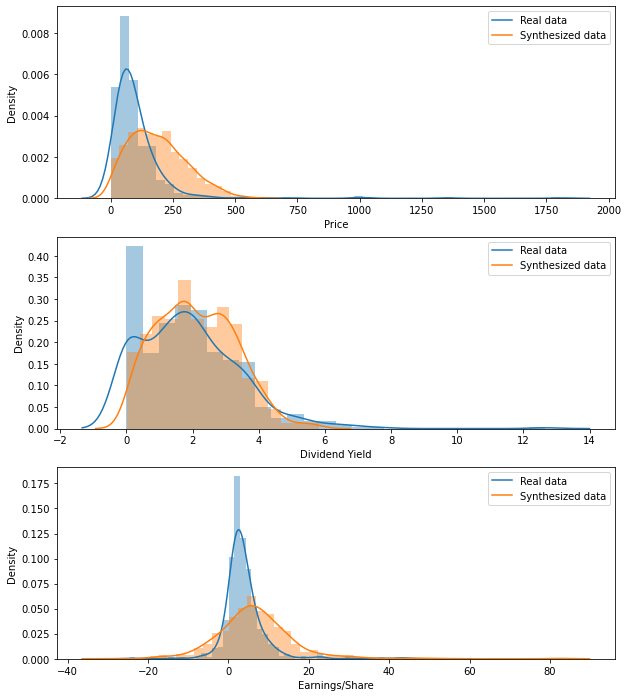

In [83]:
fix, ax = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(data['Price'], ax=ax[0])
sns.distplot(synth_df['Price'], ax=ax[0])
ax[0].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Dividend Yield'], ax=ax[1])
sns.distplot(synth_df['Dividend Yield'], ax=ax[1])
ax[1].legend(['Real data', 'Synthesized data'])

sns.distplot(data['Earnings/Share'], ax=ax[2])
sns.distplot(synth_df['Earnings/Share'], ax=ax[2])
ax[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_evo, data, [
      'Price', 'Dividend Yield', 'Earnings/Share'], 'simple')[0:2])
